In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
import time

from sklearn.datasets import make_regression
from utils.utils import make_writer

os.environ["TF_KERAS"]='1'
%matplotlib inline

2022-03-04 13:58:40.577782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 13:58:40.577807: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/stas/dsr/debugging-dl-models/ddlm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Most common bugs II

## Resources

- [Understanding LSTM networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Batch normalization explained](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c)
- [See-RNN package](https://github.com/OverLordGoldDragon/see-rnn)
- [Gradient clipping](http://proceedings.mlr.press/v28/pascanu13.html)

## Numerical instabilities

### Exploding and vanishing gradients

### A bit of theory:

- $X$ - input
- $o$ - output
- $L$ - number of layers in the network
- $l$ - layer $l$ with the transormation $f_l$ and corresponding weights $W^l$ and the hidden variable $h^l$

 $$h^l = f_l(h^{l-1})$$ $$o = f_L \circ ... \circ f_1(X)$$
 
If all $h^l$ and the input are vectors, one can write the gradient of $o$ with respect to any set of parameters $W^l$ as:

$$\partial_{W^l}o = \partial_{h^{L-1}}{h^L} ... \partial_{h^{l}}h^{l+1} \partial_{W^{l}}h^l   $$

### Vanishing gradients:

- Historically sigmoid was used as an activation function.
- It resembles a thresholding function and was appealing, since neural nets were inspired by biological neural networks, where biological neurons either fire fully or not at all.

2022-03-04 13:58:55.379823: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-04 13:58:55.379851: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (certaintylab): /proc/driver/nvidia/version does not exist
2022-03-04 13:58:55.380646: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


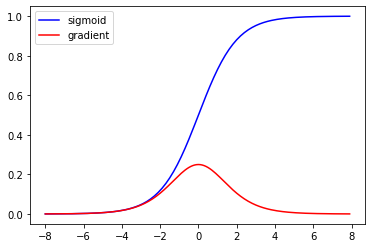

In [2]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1))

with tf.GradientTape() as tape:
    y = tf.nn.sigmoid(x)

grad = tape.gradient(y, x).numpy()
x = x.numpy()
y = y.numpy()
    
plt.plot(x, y, 'b', label='sigmoid')
plt.plot(x, grad, 'r', label='gradient') 
plt.legend()
plt.show()

- Gradients vanish for both big and small inputs.
- Multiply many layers and if the inputs are not near zero, then a gradient can vanish.
- Gradient cut off at some layer --> difficult to build deep nets.

### Exercise:

- What's the standard solution for this specific instance of the problem?
- Make a similar plot for the solution.
- What is the problem of the standard solution? Can we improve it? Please, plot it.

### Vanishing gradients in RNNs



 - Since we need to backpropagate through many time steps the gradients can vanish for long sequences.
 - Solution: use LSTM that has the cell state that plays a role of a skipped connection and helps the information to flow for the first time step to the last.

<img src = "https://drive.google.com/uc?id=1C01b5D2febgARxV8knVROaxoZMEynRcA" width="600" height="300" align="center">

#### Exploding gradients and gradient clipping



In [ ]:
M = tf.random.normal((4, 4))
print(f'A single matrix \n \n {M.numpy()}')
for i in range(100):
    M = tf.matmul(M, tf.random.normal((4, 4)))

print(f'\nAfter multiplying 100 matrices \n \n {M.numpy()}')

#### Gradient clipping

- Clip a gradient by norm:
    - $ \textbf{g} \gets min\left(1, \frac{\theta}{||\textbf{g}||}\textbf{g} \right)$
    - For example: $$\textbf{g}= [-2, 3, 6]$$ $$\theta = 5$$ $$||\textbf{g}|| = 7$$ $$\textbf{g} \gets [-2, 3, 6]\cdot \frac{5}{7}$$
    
- Clip gradient by value:
    - If $g_i < \theta_1$, then $g_i \gets \theta_1$ and $g_i > \theta_2$, then $g_i \gets \theta_2$
    - For example: $$\textbf{g}= [-2, 3, 10]$$ $$\theta_1 = 0, \theta_2 = 5$$  $$ \textbf{g} \gets [0, 3, 5]$$

    
- Clip gradient by global norm:
    - Rescales a list of tensors so that the total norm of the vector of all their norms does not exceed a threshold.
    - For example: $$\textbf{g}_1 = [-2, 3, 6]$$ $$\textbf{g}_2= [-4, 6, 12]$$ $$\theta = 14$$ $$||\textbf{g}_1|| = 7$$ $$||\textbf{g}_2|| = 14$$ $$\textbf{g}_1 \gets [-2, 3, 6]\cdot \frac{14}{\sqrt{7^2 + 14^2}}$$ $$\textbf{g}_2 \gets [-4, 6, 12]\cdot \frac{14}{\sqrt{7^2 + 14^2}} $$
    

In [5]:
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :].astype('float32'), X[n_train:, :].astype('float32')
trainy, testy = y[:n_train].astype('float32'), y[n_train:].astype('float32')

# Creat tf.Datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainy)).shuffle(trainX.shape[0]).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testy)).shuffle(testX.shape[0]).batch(32)

In [6]:
class RegressorNet(tf.keras.Model):
    def __init__(self, input_shape, optimizer):
        super(RegressorNet, self).__init__()
        
        self.loss_object = tf.keras.losses.MeanSquaredError()
        self.optimizer = optimizer
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Input(input_shape),
            tf.keras.layers.Dense(25, activation='relu', kernel_initializer='he_uniform', name='dense_1'),
            tf.keras.layers.Dense(1, activation='linear', name='out')
        ])
    
    def summary(self):
        self.regressor.summary()
    
    def call(self, X):
        return self.regressor(X)
    
    def get_loss(self, X, y_true):
        y_pred = self(X)
        l2_loss = self.loss_object(y_true, y_pred)
        return l2_loss
    
    def grad_step(self, X, y_true):
        with tf.GradientTape() as tape:
            loss = self.get_loss(X, y_true)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss, gradients

In [ ]:
# Specify an optimizer and an instance of the model
optimizer = tf.keras.optimizers.SGD(0.01, 0.9)
model_non_clipped = RegressorNet(input_shape=trainX.shape[1], optimizer=optimizer)
# Show summary
model_non_clipped.summary()

In [8]:
# Create loss objects for calculation of the mean loss across batches
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [9]:
def train(model, epochs, train_dataset, test_dataset, save_dir):
    
    writer = make_writer(os.path.join('summaries'), save_dir)
    
    for epoch in range(0, epochs + 1):
        
        train_loss.reset_states()
        test_loss.reset_states()

    
        if epoch % 10 == 0:
            print('Epoch {} is running...'.format(epoch))
        
        for X, y in train_dataset:
            # Gradient update step
            loss_train, gradients = model.grad_step(X, y)
            train_loss(loss_train)
            
        for X, y in test_dataset:
            # Gradient update step
            loss_test = model.get_loss(X, y)
            test_loss(loss_test)
        
        if epoch % 10 == 0:
            print(f'Train loss: {train_loss.result()}')

        # Tensorboard
        with writer.as_default():
            tf.summary.scalar('Test loss', test_loss.result(), step=epoch)
            tf.summary.scalar('Train loss', train_loss.result(), step=epoch)
            
            for layer_number, layer in enumerate(model.trainable_variables):
                tf.summary.histogram(layer.name, gradients[layer_number], step=epoch, buckets=1)    


In [ ]:
train(model_non_clipped, 100, train_dataset, test_dataset, 'exploding_grads/no_clipping/')

### Exercise

- Implement gradient clipping by norm OR by value OR by global norm in a new class RegressorNetClipped.
- Plot gradients with clipping.

A threshold is a parameter. In most of the cases it's a small number, usually around 1.
However, one can experiment with that, bigger numbers speed up learning, but too big of a threshold can make it unstable.
Another rule of thumb to choose a threshold is to monitor an average norm of the gradients for a big number of updates, then set the threshold to 5-10 times the value of that average.

Hint: check `tf.clip_by_value`, `tf.clip_by_norm`, `tf.clip_by_global_norm`

## OOM errors

### Common issues and causes

- Too big a tensor:
    - Too large a batch size for your model 
    - Too many fully connected layers
- Too much data:
    - Loading a too big dataset into memory instead of using, e.g. tf.data queue loading
    - Allocating to large a buffer for dataset creation
- Duplicating operations:
    - Memory leak due to creating multiple models at the same time
    - Repeatedly creating an operation (e.g. in a function that gets called many times)
- Other processes:
    - Other processes taking GPU memory

Some of you will work with images. Here is an easy way to load images off disk batch by batch, so you won't run out of memory.

**Use tf.keras.preprocessing**

```python
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
```

- This code assumes that the images are stored in a directory with sub-directories for each label.
- The output is tf.data.Dataset object